# Video Processing Pipeline Implementation Report (Software Development)

## 1. Project Overview

We have implemented a video processing pipeline that automatically extracts, transforms, and analyzes motion data from video files. The pipeline follows a well-defined sequence of operations, each building upon the previous step:

1.  **Motion Extraction**: Processing video files to extract skeletal keypoint data using MoveNet
2.  **Format Conversion**: Converting MoveNet outputs to Kinect 2D format
3.  **Depth Prediction**: Adding Z-coordinate (depth) predictions to create 3D skeletal data
4.  **Motion Trimming**: Intelligently identifying and extracting the relevant motion segment

The pipeline is exposed through a RESTful API and visualized through an interactive web interface.

## 2. Architecture and Components

### Backend Architecture

The pipeline is implemented as a series of modular components, each responsible for a specific transformation:

-   **MoveNet Extraction Module**: Uses MoveNet model to extract 2D skeletal keypoints
-   **Kinect 2D Conversion Module**: Transforms MoveNet data to match Kinect's coordinate system
-   **Kinect 3D Prediction Module**: Adds depth predictions to create full 3D skeletal data
-   **Frame Trimming Module**: Identifies the exercise segment boundaries

The API is built using FastAPI. The backend manages asynchronous processing through background tasks and maintains job state for each uploaded video.

### Frontend Architecture

The frontend is implemented using NextJs with a component-based architecture:

-   **VideoTrimmer Component**: Main interface for uploading videos and visualizing results
-   **SkeletonRenderer Component**: 3D visualization of skeletal data
-   **SkeletonContext Provider**: Manages state for animation and visualization
-   **Dashboard Integration**: Tabs interface for switching between different tools

### Data Flow

1.  User uploads a video through the frontend
2.  Video is processed on the server through all pipeline stages
3.  Processing status is tracked and communicated to the frontend
4.  Processed data is retrieved and visualized once processing is complete

## 3. Implementation Details

### Backend Implementation

#### Video Processing Endpoint

We implemented a video processing endpoint that:

-   Handles file uploads securely
-   Generates unique job IDs for tracking
-   Processes videos asynchronously
-   Reports detailed status information
-   Provides endpoints for retrieving results at each pipeline stage

```python
@app.post("/process-video")
async def process_video(file: UploadFile = File(...), background_tasks: BackgroundTasks = BackgroundTasks()):
    # Generate unique job ID
    job_id = str(uuid.uuid4())
    
    # Create processing directory
    job_dir = OUTPUT_DIR / job_id
    job_dir.mkdir(exist_ok=True)
    
    # Save uploaded file
    video_path = job_dir / file.filename
    with open(video_path, "wb") as f:
        shutil.copyfileobj(file.file, f)
    
    # Start processing in background
    background_tasks.add_task(process_video_task, job_id, str(video_path))
    
    # Return job ID
    return {"job_id": job_id, "message": "Processing started"}

```

#### Motion Extraction

The MoveNet extraction module efficiently processes video frames:

-   Extracts keypoints from each video frame
-   Maps keypoints to the required skeletal format
-   Saves results as structured CSV data

#### ML Model Integration

The pipeline integrates three key machine learning models:

1.  **MoveNet**: For initial pose detection from video
2.  **Kinect 2D Conversion Model**: For coordinate transformation
3.  **Depth Prediction Model**: For Z-coordinate estimation
4.  **Frame Trimming Model**: For identifying exercise segment boundaries

Each model is cleanly integrated with:

-   Proper error handling
-   Fallback mechanisms
-   Data format validation

### Frontend Implementation

#### Video Upload and Processing

The frontend handles the complete workflow:

-   File selection and upload UI
-   Processing status indicators
-   Error handling and reporting
-   Data visualization once processing completes

#### Data Visualization

The visualization components provide:

-   Side-by-side comparison of original and trimmed data
-   Interactive timeline with color-coded frame indicators
-   Playback controls for animation
-   3D skeleton visualization with rotation capabilities

#### Status Tracking

The frontend implements a status tracking through:

-   Regular polling of job status
-   Clear progress indicators
-   Detailed error reporting
-   Result statistics (frames kept/removed)

#### Responsive Design

The interface is responsive and user-friendly:

-   Card-based layout
-   Clear status indicators
-   Adaptive grid layout for different screen sizes
-   Intuitive controls

## 4. Deployment

### Server Requirements

The backend requires:

-   Python 3.8+
-   TensorFlow 2.x
-   FastAPI and Uvicorn
-   Required ML models in the `models` directory
-   Approximately 2GB RAM for processing

### Client Requirements

The frontend requires:

-   Modern web browser with WebGL support
-   JavaScript enabled
-   Approximately 100MB of available memory

### Installation and Setup

1.  **Backend Setup**:
    
    ```bash
    # Install dependencies
    pip install -r requirements.txt
    
    # Create required directories
    mkdir -p models outputs/kinect2d outputs/kinect3d outputs/trimmed
    
    # Place ML models in models directory
    cp kinect_cutting_model.keras models/
    cp kinect_cutting_scaler.pkl models/
    
    # Start the server
    python main.py
    
    ```
    
2.  **Frontend Setup**:
    
    ```bash
    # Install dependencies
    npm install
    
    # Configure backend URL
    export NEXT_PUBLIC_BACKEND_URL=http://localhost:8000
    
    # Start development server
    npm run dev
    
    ```
    

## 5. Usage

### Basic Workflow

1.  Navigate to the dashboard
2.  Select the "Visualize Video" tab
3.  Click "Upload Video File" and select a video
4.  Wait for processing to complete
5.  Explore the visualized results:
    -   Top timeline shows which frames were kept (green) vs. removed (red)
    -   Left panel shows the Kinect 3D data
    -   Right panel shows the trimmed output
    -   Use play/pause and timeline slider to animate through frames

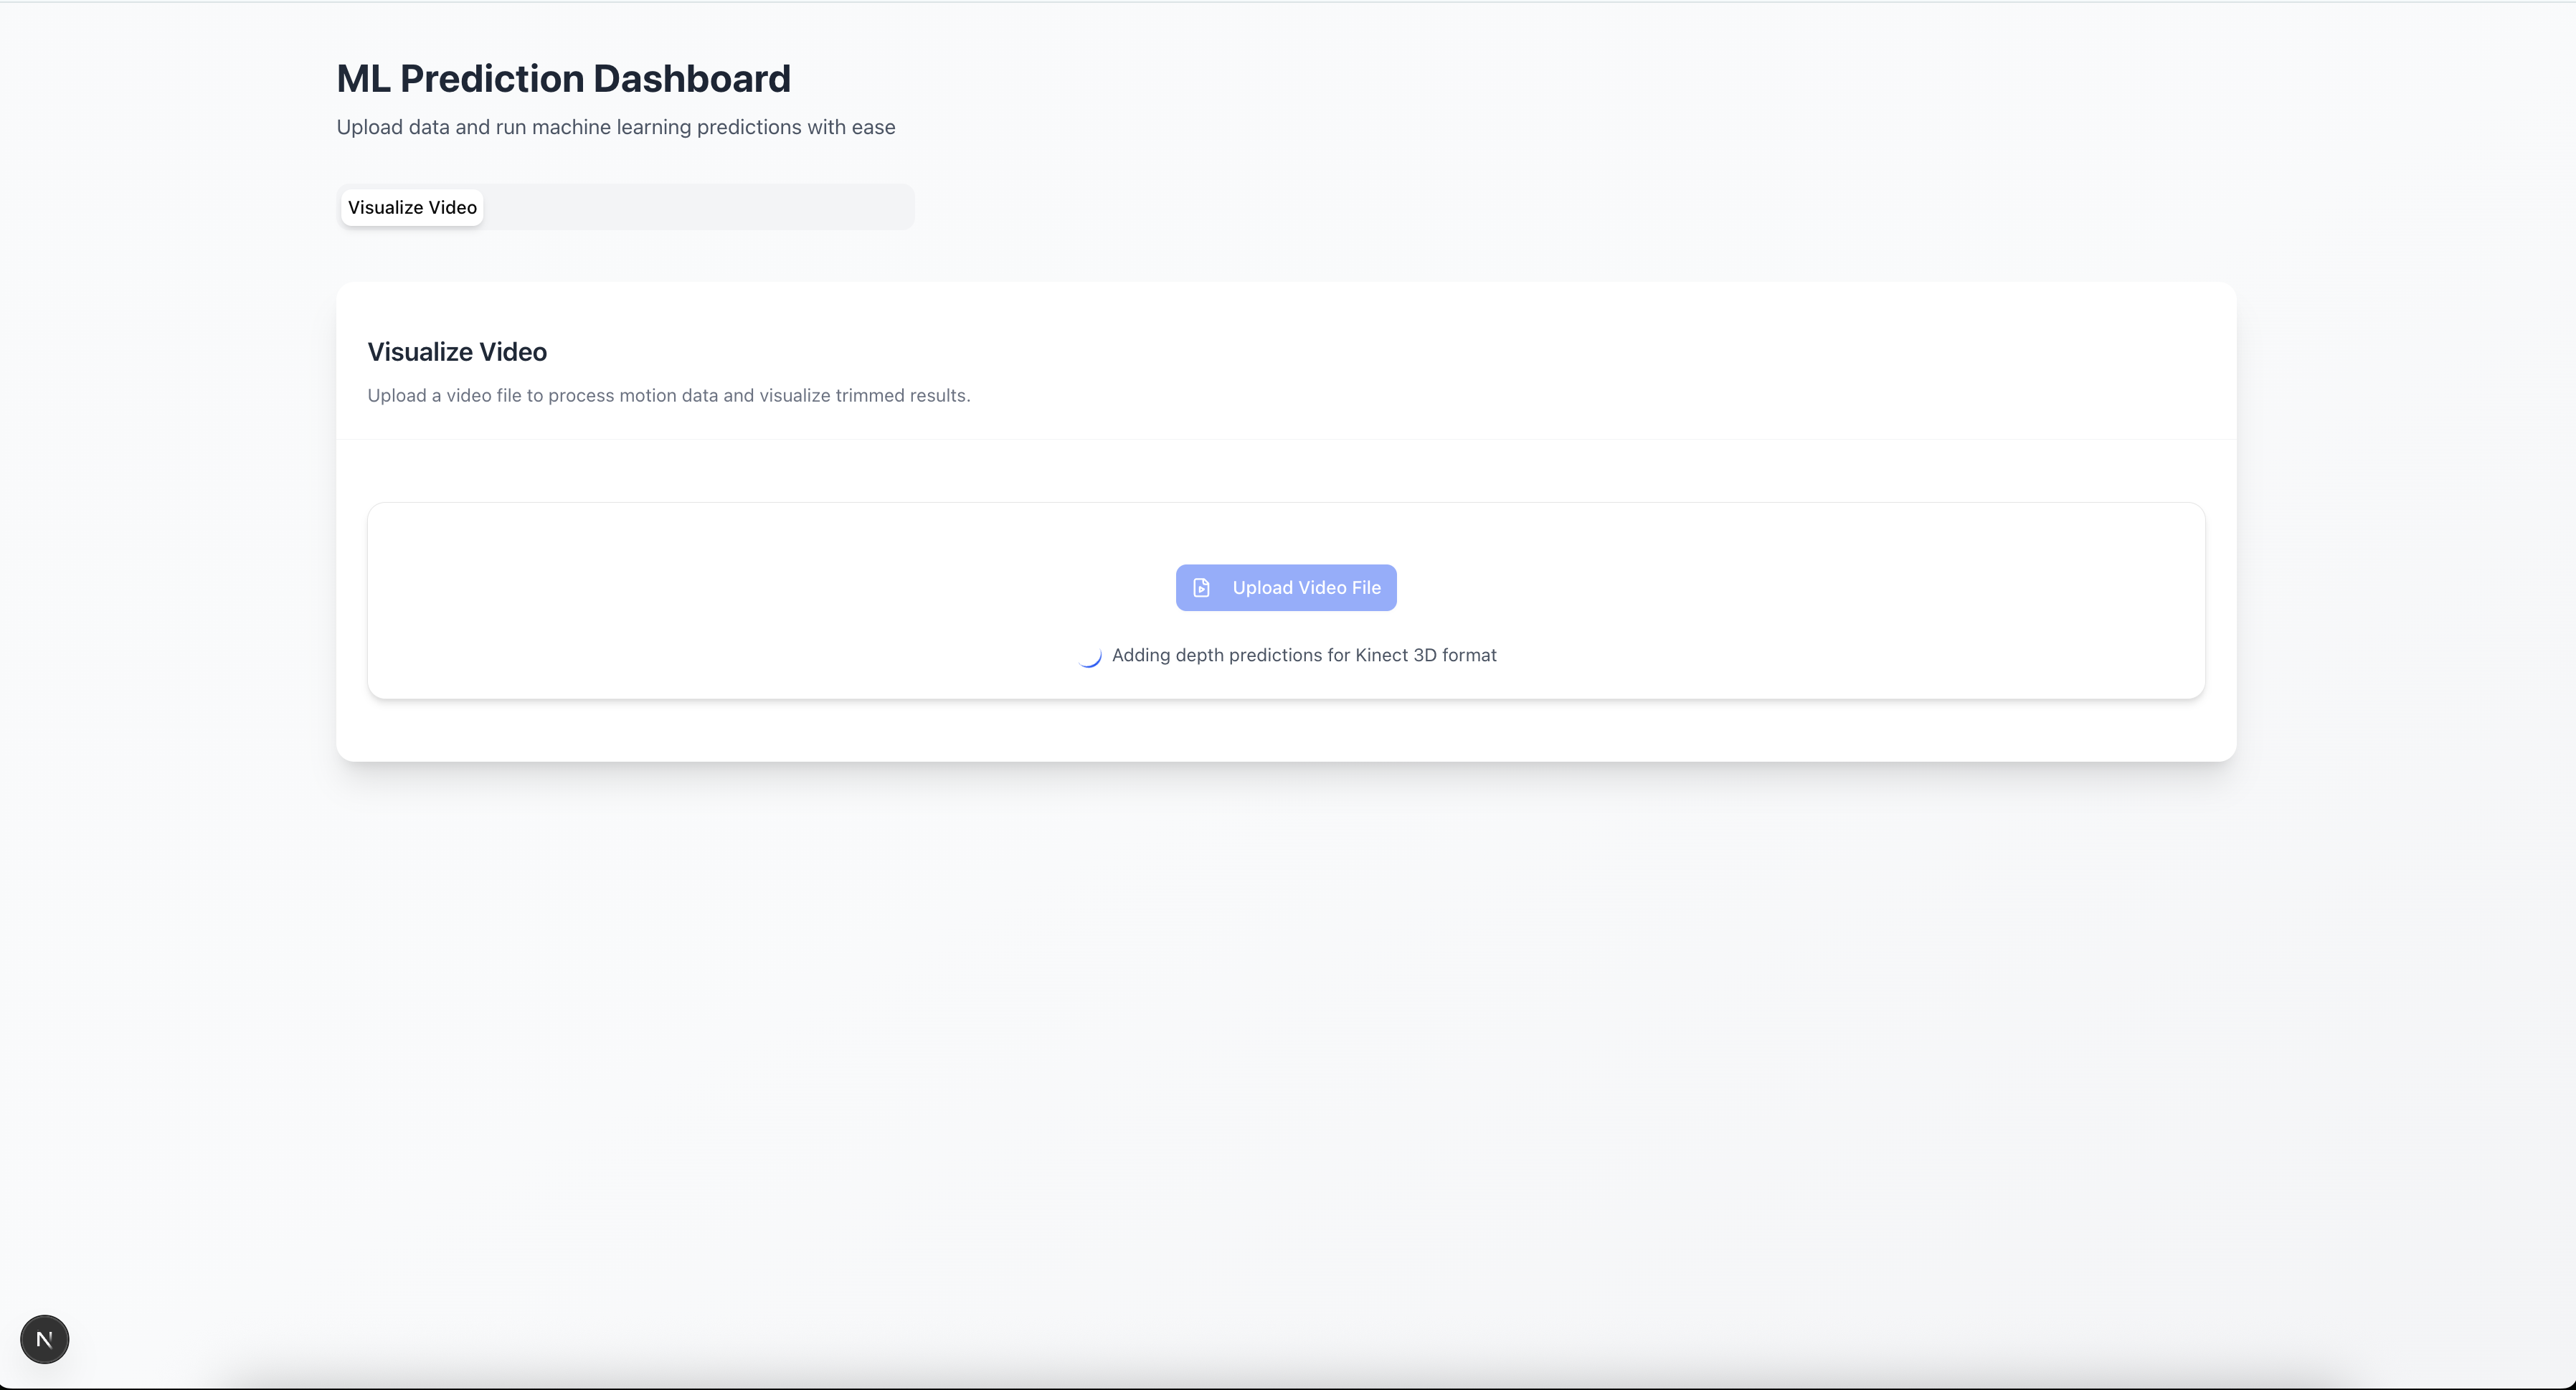

### Advanced Features

-   **Auto-Rotation**: Toggle 3D view rotation
-   **Frame Navigation**: Use the slider to navigate to specific frames
-   **Frame Status**: View which frames were kept or removed
-   **Percentage Analysis**: See statistics on what percentage of frames were trimmed

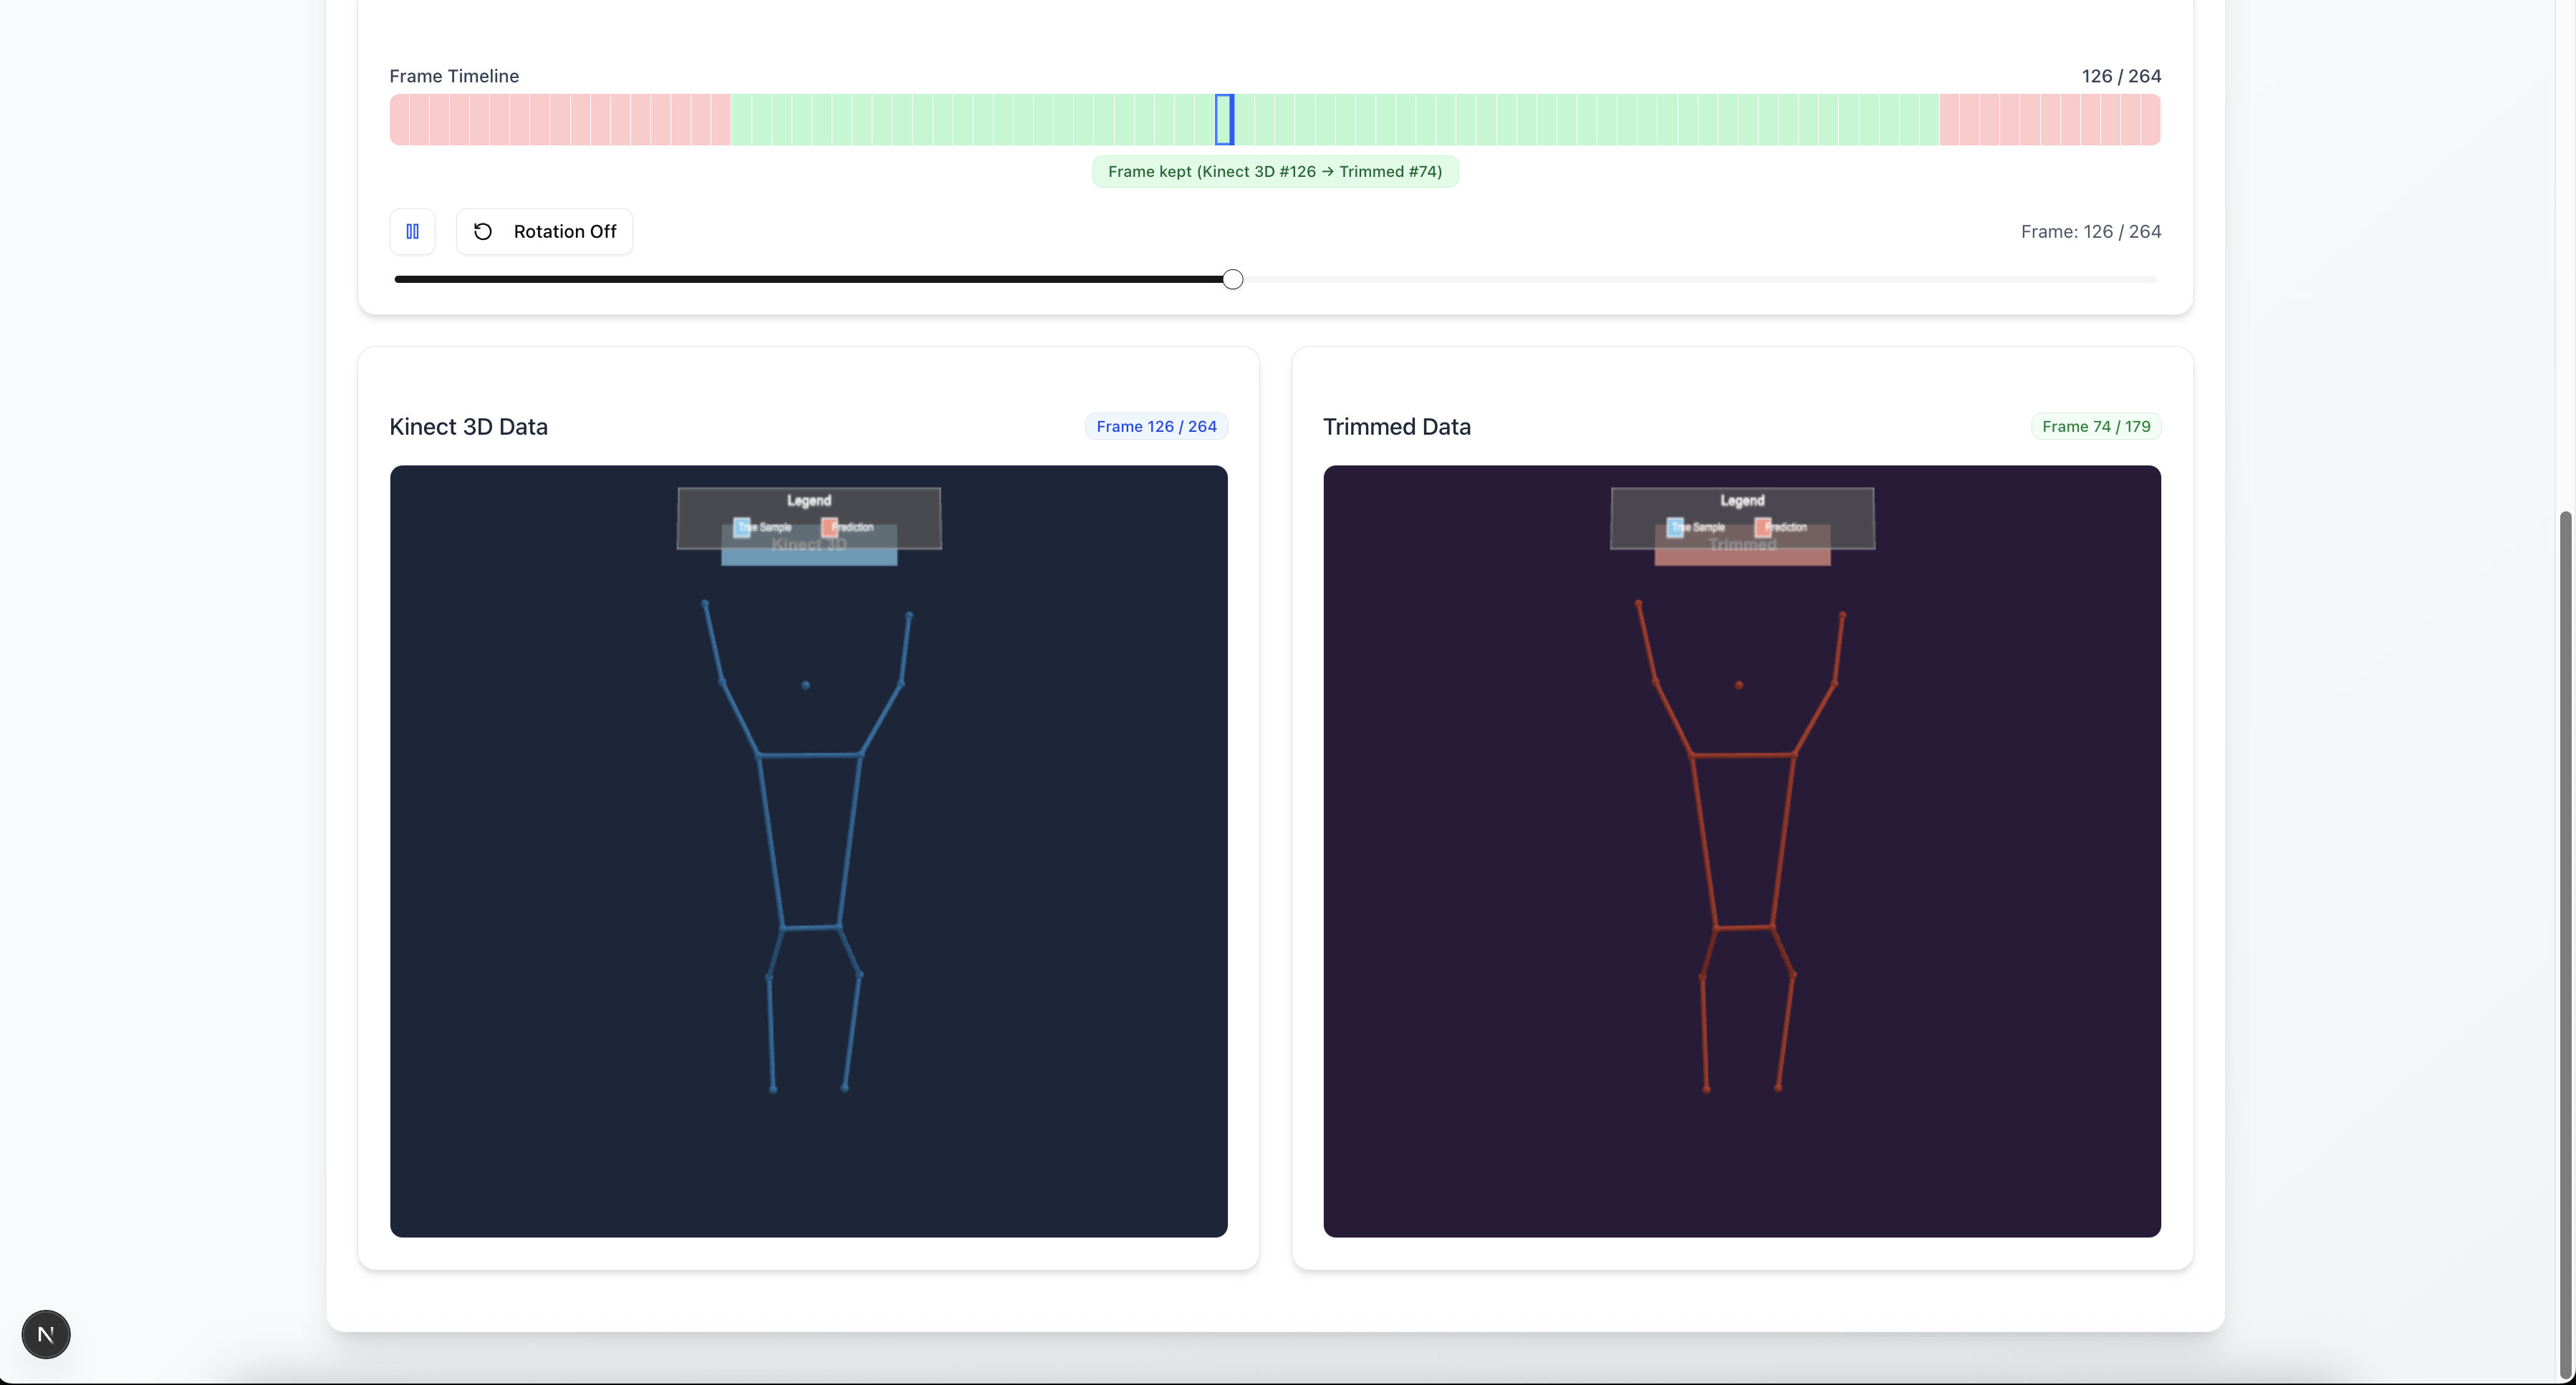

## 6. Testing

### Backend Testing

The backend components were tested for:

-   Correct handling of various video formats
-   Proper error handling with invalid inputs
-   Memory management with large videos
-   Concurrent processing of multiple videos

### Frontend Testing

The frontend was tested across:

-   Different browsers (Chrome, Firefox, Safari, Edge)
-   Various screen sizes
-   Different interaction patterns
-   Error recovery scenarios

### Pipeline Testing

Complete end-to-end pipeline testing confirmed:

-   Correct data flow between all stages
-   Proper file handling
-   Accurate visualization of results


## 7. Conclusion

We have successfully implemented a comprehensive video processing and analysis pipeline that automatically extracts, transforms, and analyzes motion data from video files. The system provides an intuitive interface for visualizing the results and comparing original and trimmed data.

The modular architecture ensures maintainability and extensibility, while the  error handling makes the system resilient to unexpected inputs or processing failures. The use of background processing and job tracking enables efficient handling of computationally intensive tasks without blocking the user interface.

---

# Deep Learning Improvements

## 1. MoveNet To Kinect

### Improvements:
* **Train on uncut sequences:** Previously, we trained the model on the cut sequences. This time, we decided to use the full uncut dataset. Both because it gives us more data, and because the real input from MoveNet will consist of uncut sequences.
* **PReLU activation:** We experimented with different activation functions. Previously we used ReLU. Parametric ReLU (PReLU) performed better, so we switched to that.

### Other ideas (no improvement):
* Dropout (after each dense layer, with various rates) 
* L2 regularization
* Batch normalization
* Different optimizers such as RMSProp and AdamW (Adam still performs best)
* Different loss functions such as Huber and log-cosh (MSE still performs best)
* He initialization instead of Glorot
* Data augmentation (rotation, mirroring, jitter)

### Results:

**Test MAE = 1.37 cm** (previously 1.39 cm, a slight improvement)

